# Paper Figures: Figure 4B - Dopamine AUC Aligned to Sigmoidal Transitions

This notebook generates extended Figure 4 showing dopamine (photometry) response aligned to the transition point where animals shift cluster membership. Uses sigmoidal transition points calculated in `src/assemble_all_data.py`.

**Figure 4B: Transition-Aligned Dopamine Response** — Photometry AUC heatmaps and time series for each rat, centered at their individual transition points.

In [99]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Register dill/pathlib compatibility shim BEFORE importing dill
sys.path.insert(0, str(Path("../src").resolve()))
from pickle_compat import enable_dill_pathlib_compat
enable_dill_pathlib_compat()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.optimize import curve_fit

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP_DIV,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import (
    save_figure, scale_vlim_to_data, make_heatmap
)

from utils import (
    make_realigned_trials,
    recalculate_time_moving
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP_DIV  # Use shared colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Assembled Data
Load the complete dataset with transition points and trial-aligned indices.

In [100]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_movement = data["snips_movement"]

x_array = recalculate_time_moving(x_array, snips_movement, threshold=0.01)

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - x_array has trial_aligned column: {'trial_aligned' in x_array.columns}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"\nDeplete + 45NaCl subset:")
d45_subset = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
d45_aligned = d45_subset.dropna(subset=['trial_aligned'])
print(f"  - Total trials: {len(d45_subset)}")
print(f"  - Trials with valid alignment: {len(d45_aligned)}")
print(f"  - Number of unique animals: {d45_aligned['id'].nunique()}")

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 19)
  - x_array has trial_aligned column: True
  - snips_photo shape: (1960, 200)

Deplete + 45NaCl subset:
  - Total trials: 490
  - Trials with valid alignment: 392
  - Number of unique animals: 8


## Prepare Realigned Data

In [101]:
# Get the deplete + 45NaCl animals with valid transition fits
subset_aligned = (
    x_array
    .query("condition == 'deplete' & infusiontype == '45NaCl'")
    .dropna(subset=['trial_aligned'])
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

# Get animal info
animals = sorted(subset_aligned['id'].unique())
print(f"Animals with both transitions and deplete+45NaCl trials: {animals}")
print(f"Number of animals: {len(animals)}")

# Show summary statistics
print(f"\nTrial counts per animal:")
for animal in animals:
    n_trials = len(subset_aligned.query("id == @animal"))
    print(f"  {animal}: {n_trials} trials")

# make df that only includes realigned trials where all rats are included
subset_aligned_8 = (
    subset_aligned
    .groupby("trial_aligned", group_keys=False)
    .filter(lambda g: len(g) == 8)
    .copy()
)

Animals with both transitions and deplete+45NaCl trials: ['PB26', 'PB30', 'PB31', 'PB46', 'PB71', 'PB72', 'PB73', 'PB75']
Number of animals: 8

Trial counts per animal:
  PB26: 49 trials
  PB30: 49 trials
  PB31: 49 trials
  PB46: 49 trials
  PB71: 49 trials
  PB72: 49 trials
  PB73: 49 trials
  PB75: 49 trials


## Figure 4B: Transition-Aligned Heatmaps

## Helper Functions for Plotting

In [102]:
# Define sigmoid function for fitting
def sigmoid(x, L, x0, k, b):
    """4-parameter sigmoid function."""
    return L / (1 + np.exp(-k * (x - x0))) + b


def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    """Plot AUC data grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[3], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[3], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[3], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None




def plot_realigned_behaviour(df, column, ax=None, first_trial=0, include_steepness=False):
    """Plot behavior (time_moving) grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).time_moving
    sd = df.groupby(column).std(numeric_only=True).time_moving.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[1], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[1], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[1], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[1], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None

    sns.despine(ax=ax, offset=5, right=True)
    ax.set_yticks([])
    ax.set_ylabel("Time Moving")
    

def include_only_complete_trials(df, group_col="trial_aligned", n_required=8):
    """Filter df to include only groups with at least n_required entries."""
    return (
        df
        .groupby(group_col, group_keys=False)
        .filter(lambda g: len(g) >= n_required)
        .copy()
    )

## Figure 4B-1: Original vs. Realigned AUC Comparison

Original order - transition midpoint: 16.1, steepness (k): -0.206
Realigned - transition midpoint: 1.0, steepness (k): -0.796


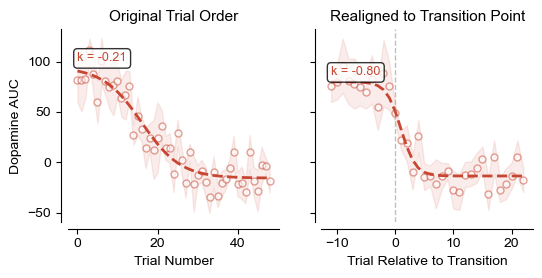

In [103]:
# Compare original vs realigned AUC
f, ax = plt.subplots(ncols=2, figsize=(6, 2.5), sharey=True)

# Left plot: Original trial order
popt_orig = plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=True)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order', fontsize=11)
ax[0].set_ylabel('Dopamine AUC', fontsize=10)

# Right plot: Realigned to transition
popt_realigned = plot_auc_and_sigmoid(include_only_complete_trials(subset_aligned_8), "trial_aligned", ax=ax[1], 
                                      first_trial=int(include_only_complete_trials(subset_aligned_8).trial_aligned.min()),
                                      include_steepness=True)
ax[1].set_xlabel('Trial Relative to Transition', fontsize=10)
ax[1].set_title('Realigned to Transition Point', fontsize=11)


# Mark transition point
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5)

if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions", FIGSFOLDER)


print(f"Original order - transition midpoint: {popt_orig[1]:.1f}, steepness (k): {popt_orig[2]:.3f}")
print(f"Realigned - transition midpoint: {popt_realigned[1]:.1f}, steepness (k): {popt_realigned[2]:.3f}")

## Figure 4B-2: Dopamine and Behavior Co-Aligned to Transition

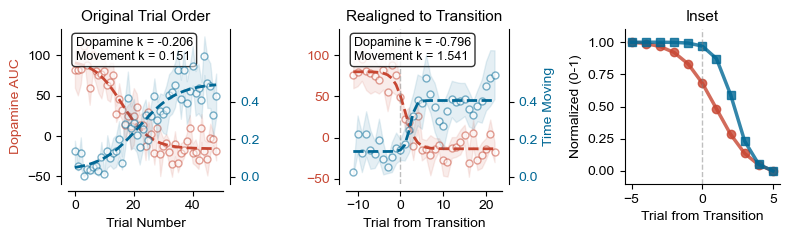


Steepness of transitions (k values):
  Original trial order:
    Dopamine:   -0.206
    Movement:    0.151
  Realigned to transition:
    Dopamine:   -0.796
    Movement:    1.541
  Right panel (-5 to +5 trials window): reuses fitted parameters from middle panel


In [104]:
# Combined figure: Original order, Realigned, and Normalized window (-5 to +5)
f, ax = plt.subplots(ncols=3, figsize=(8, 2.5))

# First, fit movement sigmoids for original and realigned
movement_by_trial_orig = subset_aligned.groupby('trial')['time_moving'].mean()
movement_by_trial_realigned = include_only_complete_trials(subset_aligned).groupby('trial_aligned')['time_moving'].mean()

try:
    popt_behav_orig, _ = curve_fit(sigmoid, movement_by_trial_orig.index.values, movement_by_trial_orig.values,
                                   p0=[max(movement_by_trial_orig.values), np.median(movement_by_trial_orig.index), 1, min(movement_by_trial_orig.values)],
                                   maxfev=10000)
    k_behav_orig = popt_behav_orig[2]

except Exception as e:
    k_behav_orig = np.nan
    print(f"Failed to fit movement (original): {e}")

try:
    popt_behav_realigned, _ = curve_fit(sigmoid, movement_by_trial_realigned.index.values, movement_by_trial_realigned.values,
                                        p0=[max(movement_by_trial_realigned.values), np.median(movement_by_trial_realigned.index), 1, min(movement_by_trial_realigned.values)],
                                        maxfev=10000)
    k_behav_realigned = popt_behav_realigned[2]
except Exception as e:
    k_behav_realigned = np.nan
    print(f"Failed to fit movement (realigned): {e}")

# Left plot: Original trial order with dual axes
plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=False)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order', fontsize=11)
ax[0].set_ylabel('Dopamine AUC', fontsize=10, color=colors[3])
# Add steepness text for both curves
ax[0].text(0.05, 0.95, f"Dopamine k = {popt_orig[2]:.3f}\nMovement k = {k_behav_orig:.3f}", 
          transform=ax[0].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_left = ax[0].twinx()
plot_realigned_behaviour(subset_aligned, "trial", ax=ax2_left, include_steepness=False)

# Middle plot: Realigned to transition with dual axes
plot_auc_and_sigmoid(include_only_complete_trials(subset_aligned), "trial_aligned", ax=ax[1], 
                    first_trial=int(subset_aligned.trial_aligned.min()),
                    include_steepness=False)
ax[1].set_xlabel('Trial from Transition', fontsize=10)
ax[1].set_title('Realigned to Transition', fontsize=11)
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

ax[1].tick_params(axis='y', labelcolor=colors[3])
ax[1].set_xticks([-10, 0, 10, 20])
# Add steepness text for both curves
ax[1].text(0.05, 0.95, f"Dopamine k = {popt_realigned[2]:.3f}\nMovement k = {k_behav_realigned:.3f}", 
          transform=ax[1].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_mid = ax[1].twinx()
ax2_mid.sharey(ax2_left)
plot_realigned_behaviour(include_only_complete_trials(subset_aligned), "trial_aligned", ax=ax2_mid,
                        first_trial=int(include_only_complete_trials(subset_aligned).trial_aligned.min()),
                        include_steepness=False)
ax2_mid.set_ylabel('Time Moving', fontsize=10, color=colors[1])

for axis in [ax2_left, ax2_mid]:
    sns.despine(ax=axis, offset=5, left=True, right=False)
    axis.spines['right'].set_position(('outward', 5))
    axis.tick_params(axis='y', labelcolor=colors[1])
    # axis.set_ylim([-0.05, 0.41])
    axis.set_yticks([0,0.2,0.4])

# Right plot: Normalized fitted curves in -5 to +5 window
window_trials = np.arange(-5, 6)

# Use the already-fitted sigmoid parameters from the middle panel
y_dop_fit = sigmoid(window_trials, *popt_realigned)
y_behav_fit = sigmoid(window_trials, *popt_behav_realigned)

# Normalize both fitted curves to 0-1 scale independently
dop_min, dop_max = y_dop_fit.min(), y_dop_fit.max()
behav_min, behav_max = y_behav_fit.min(), y_behav_fit.max()

dopamine_norm = (y_dop_fit - dop_min) / (dop_max - dop_min) if dop_max > dop_min else np.ones_like(y_dop_fit) * 0.5
behavior_norm = (y_behav_fit - behav_min) / (behav_max - behav_min) if behav_max > behav_min else np.ones_like(y_behav_fit) * 0.5

# Invert behavior so it goes from high to low (like dopamine)
behavior_inverted = 1 - behavior_norm

# Plot on right axes
ax[2].plot(window_trials, dopamine_norm, 'o-', color=colors[3], linewidth=2.5, 
        markersize=6, label='Dopamine', alpha=0.8)
ax[2].plot(window_trials, behavior_inverted, 's-', color=colors[1], linewidth=2.5, 
        markersize=6, label='Movement (inverted)', alpha=0.8)
ax[2].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax[2].set_xlabel('Trial from Transition', fontsize=10)
ax[2].set_ylabel('Normalized (0-1)', fontsize=10)
ax[2].set_title('Inset', fontsize=11)
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_xticks([-5, 0, 5])

sns.despine(ax=ax[2])

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions_with_behavior", FIGSFOLDER)
plt.show()

# Print summary of steepness values
print(f"\nSteepness of transitions (k values):")
print(f"  Original trial order:")
print(f"    Dopamine:  {popt_orig[2]:7.3f}")
print(f"    Movement:  {k_behav_orig:7.3f}")
print(f"  Realigned to transition:")
print(f"    Dopamine:  {popt_realigned[2]:7.3f}")
print(f"    Movement:  {popt_behav_realigned[2]:7.3f}")
print(f"  Right panel (-5 to +5 trials window): reuses fitted parameters from middle panel")

## Cross-Correlation Analysis (Moved to Figure 5)

**See `figure_5_paper.ipynb` for lagged correlation analysis between dopamine and behavior signals.**

This analysis computes optimal lag for each animal where Pearson r is maximized across:
- Transition-aligned window (±5 trials from transition point)
- Full data window (±10 trials across all trials)

The core correlation logic is abstracted into `compute_optimal_lag_correlation()` function for reusability.

In [94]:
from scipy.stats import pearsonr

# Compute cross-correlation for each animal using trial-by-trial values
cross_corr_results = []

for animal in animals:
    # Get this animal's data restricted to -15 to +15 trials, sorted by trial_aligned
    animal_data = include_only_complete_trials(subset_aligned).query("id == @animal & trial_aligned >= -15 & trial_aligned <= 15").sort_values('trial_aligned')
    
    if len(animal_data) < 5:
        print(f"Warning: {animal} has {len(animal_data)} trials in window - skipping")
        continue
    
    # Extract trial-by-trial values
    dopamine_auc = animal_data['auc_snips'].values
    time_moving = animal_data['time_moving'].values
    trial_aligned = animal_data['trial_aligned'].values
    
    # Normalize each to [0, 1]
    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
    
    # Lags to test for correlation
    n_trials = len(dopamine_norm)
    lags = np.arange(-(n_trials-1), n_trials)
    
    # Restrict to valid lags within [-5, +5] window
    valid_lag_mask = (lags >= -5) & (lags <= 5)
    valid_lags = lags[valid_lag_mask]
    
    # Compute Pearson r for each valid lag and find the one with strongest correlation
    pearson_r_by_lag = []
    min_overlap = 5
    
    for lag in valid_lags:
        # Guard: ensure minimum overlap at this lag
        if len(dopamine_norm) - abs(lag) < min_overlap:
            pearson_r_by_lag.append(np.nan)
            continue
        
        # Shift signals by lag
        if lag < 0:
            dop_lag = dopamine_norm[:lag]
            behav_lag = behavior_norm[-lag:]
        elif lag > 0:
            dop_lag = dopamine_norm[lag:]
            behav_lag = behavior_norm[:-lag]
        else:
            dop_lag = dopamine_norm
            behav_lag = behavior_norm
        
        # Compute Pearson r at this lag
        try:
            r, _ = pearsonr(dop_lag, behav_lag)
            pearson_r_by_lag.append(r)
        except:
            pearson_r_by_lag.append(np.nan)
    
    # Find lag with maximum |pearson_r| (strongest correlation)
    pearson_r_by_lag = np.array(pearson_r_by_lag)
    valid_idx = ~np.isnan(pearson_r_by_lag)
    
    if np.any(valid_idx):
        # Get index of max |r| among non-NaN values
        max_r_idx_in_valid = np.argmax(np.abs(pearson_r_by_lag[valid_idx]))
        max_lag_idx = np.where(valid_idx)[0][max_r_idx_in_valid]
        max_lag = valid_lags[max_lag_idx]
        pearson_r = pearson_r_by_lag[max_lag_idx]
        
        # Get p-value at optimal lag
        if max_lag < 0:
            dop_lag = dopamine_norm[:max_lag]
            behav_lag = behavior_norm[-max_lag:]
        elif max_lag > 0:
            dop_lag = dopamine_norm[max_lag:]
            behav_lag = behavior_norm[:-max_lag]
        else:
            dop_lag = dopamine_norm
            behav_lag = behavior_norm
        
        try:
            _, p_value = pearsonr(dop_lag, behav_lag)
        except:
            p_value = np.nan
    else:
        max_lag = np.nan
        pearson_r = np.nan
        p_value = np.nan
    
    cross_corr_results.append({
        'animal': animal,
        'lag_trials': max_lag,
        'pearson_r': pearson_r,
        'p_value': p_value,
        'n_trials': len(animal_data),
    })

cross_corr_df = pd.DataFrame(cross_corr_results)

print("\nTrial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)")
print("Window: -5 to +5 trials from transition (optimal lag selected by max |Pearson r|)")
print(cross_corr_df.to_string(index=False))
print(f"\nLag Summary (in trials):")
print(f"  Mean lag: {cross_corr_df['lag_trials'].mean():.2f} trials")
print(f"  Median lag: {cross_corr_df['lag_trials'].median():.2f} trials")
print(f"  Std: {cross_corr_df['lag_trials'].std():.2f} trials")
print(f"\nMean Pearson correlation at optimal lag: {cross_corr_df['pearson_r'].mean():.3f}")


Trial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)
Window: -5 to +5 trials from transition (optimal lag selected by max |Pearson r|)
animal  lag_trials  pearson_r  p_value  n_trials
  PB26           0  -0.646115 0.000272        27
  PB30          -4  -0.402501 0.056895        27
  PB31          -1  -0.511776 0.007529        27
  PB46           5  -0.416323 0.053945        27
  PB71          -5  -0.502145 0.017246        27
  PB72           4  -0.457627 0.028114        27
  PB73          -1  -0.740216 0.000015        27
  PB75           0  -0.675782 0.000110        27

Lag Summary (in trials):
  Mean lag: -0.25 trials
  Median lag: -0.50 trials
  Std: 3.45 trials

Mean Pearson correlation at optimal lag: -0.544


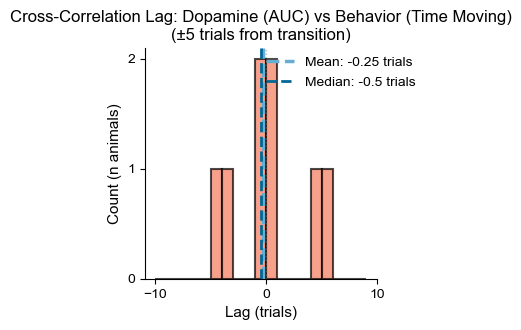

In [95]:
# Plot histogram of lags
f, ax = plt.subplots(figsize=(3, 3))

# Histogram of trial-by-trial lags
ax.hist(cross_corr_df['lag_trials'], bins=np.arange(-10, 10, 1), 
        color=colors[2], alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axvline(cross_corr_df['lag_trials'].mean(), color=colors[0], linestyle='--', linewidth=2.5,
          label=f'Mean: {cross_corr_df["lag_trials"].mean():.2f} trials')
ax.axvline(cross_corr_df['lag_trials'].median(), color=colors[1], linestyle='--', linewidth=2,
          label=f'Median: {cross_corr_df["lag_trials"].median():.1f} trials')
ax.axvline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Lag (trials)', fontsize=11)
ax.set_ylabel('Count (n animals)', fontsize=11)
ax.set_title('Cross-Correlation Lag: Dopamine (AUC) vs Behavior (Time Moving)\n(±5 trials from transition)', fontsize=12)
ax.set_xticks(range(-10, 11, 10))
ax.set_yticks([0,1,2])
ax.legend(fontsize=10, loc=[0.5, 0.8], frameon=False)
sns.despine(ax=ax)

if SAVE_FIGS:
    save_figure(f, "fig4b_cross_correlation_lag", FIGSFOLDER)



## Cross-correlation on full data (maybe move to separate notebook)

In [96]:
from scipy.stats import pearsonr

# Compute cross-correlation for each animal using trial-by-trial values
cross_corr_results_full = []

subset_condition = (x_array
                    .query("condition == 'deplete' & infusiontype == '45NaCl'")
                    )
animals = subset_condition.id.unique()

for animal in animals:
    # Get this animal's data for all trials, sorted by trial
    animal_data = (subset_condition
                   .query("id == @animal")
                   .sort_values('trial')
    )
    
    if len(animal_data) < 5:
        print(f"Warning: {animal} has {len(animal_data)} trials in window - skipping")
        continue
    
    # Extract trial-by-trial values
    dopamine_auc = animal_data['auc_snips'].values
    time_moving = animal_data['time_moving'].values
    trial = animal_data['trial'].values
    
    # Normalize each to [0, 1]
    dopamine_norm = (dopamine_auc - dopamine_auc.min()) / (dopamine_auc.max() - dopamine_auc.min() + 1e-10)
    behavior_norm = (time_moving - time_moving.min()) / (time_moving.max() - time_moving.min() + 1e-10)
    
    # Lags to test for correlation
    n_trials = len(dopamine_norm)
    lags = np.arange(-(n_trials-1), n_trials)
    
    # Restrict to valid lags within [-10, +10] window
    valid_lag_mask = (lags >= -10) & (lags <= 10)
    valid_lags = lags[valid_lag_mask]
    
    # Compute Pearson r for each valid lag and find the one with strongest correlation
    pearson_r_by_lag = []
    min_overlap = 5
    
    for lag in valid_lags:
        # Guard: ensure minimum overlap at this lag
        if len(dopamine_norm) - abs(lag) < min_overlap:
            pearson_r_by_lag.append(np.nan)
            continue
        
        # Shift signals by lag
        if lag < 0:
            dop_lag = dopamine_norm[:lag]
            behav_lag = behavior_norm[-lag:]
        elif lag > 0:
            dop_lag = dopamine_norm[lag:]
            behav_lag = behavior_norm[:-lag]
        else:
            dop_lag = dopamine_norm
            behav_lag = behavior_norm
        
        # Compute Pearson r at this lag
        try:
            r, _ = pearsonr(dop_lag, behav_lag)
            pearson_r_by_lag.append(r)
        except:
            pearson_r_by_lag.append(np.nan)
    
    # Find lag with maximum |pearson_r| (strongest correlation)
    pearson_r_by_lag = np.array(pearson_r_by_lag)
    valid_idx = ~np.isnan(pearson_r_by_lag)
    
    if np.any(valid_idx):
        # Get index of max |r| among non-NaN values
        max_r_idx_in_valid = np.argmax(np.abs(pearson_r_by_lag[valid_idx]))
        max_lag_idx = np.where(valid_idx)[0][max_r_idx_in_valid]
        max_lag = valid_lags[max_lag_idx]
        pearson_r = pearson_r_by_lag[max_lag_idx]
        
        # Get p-value at optimal lag
        if max_lag < 0:
            dop_lag = dopamine_norm[:max_lag]
            behav_lag = behavior_norm[-max_lag:]
        elif max_lag > 0:
            dop_lag = dopamine_norm[max_lag:]
            behav_lag = behavior_norm[:-max_lag]
        else:
            dop_lag = dopamine_norm
            behav_lag = behavior_norm
        
        try:
            _, p_value = pearsonr(dop_lag, behav_lag)
        except:
            p_value = np.nan
    else:
        max_lag = np.nan
        pearson_r = np.nan
        p_value = np.nan
    
    cross_corr_results_full.append({
        'animal': animal,
        'lag_trials': max_lag,
        'pearson_r': pearson_r,
        'p_value': p_value,
        'n_trials': len(animal_data),
    })

cross_corr_df_full = pd.DataFrame(cross_corr_results_full)

print("\nTrial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)")
print("Window: full data (optimal lag selected by max |Pearson r|)")
print(cross_corr_df_full.to_string(index=False))
print(f"\nLag Summary (in trials):")
print(f"  Mean lag: {cross_corr_df_full['lag_trials'].mean():.2f} trials")
print(f"  Median lag: {cross_corr_df_full['lag_trials'].median():.2f} trials")
print(f"  Std: {cross_corr_df_full['lag_trials'].std():.2f} trials")
print(f"\nMean Pearson correlation at optimal lag: {cross_corr_df_full['pearson_r'].mean():.3f}")


Trial-by-Trial Cross-Correlation Analysis (Dopamine AUC vs Time Moving)
Window: full data (optimal lag selected by max |Pearson r|)
animal  lag_trials  pearson_r      p_value  n_trials
  PB26          -2  -0.623906 2.793139e-06        49
  PB27           5  -0.447310 2.332329e-03        49
  PB30         -10  -0.598693 5.669590e-05        49
  PB31          -1  -0.732521 3.259394e-09        49
  PB46           0  -0.495101 2.984694e-04        49
  PB48           7  -0.381760 1.260590e-02        49
  PB71           8   0.309715 4.877343e-02        49
  PB72           0  -0.617633 2.272164e-06        49
  PB73          -1  -0.624655 2.083520e-06        49
  PB75           0  -0.578017 1.366098e-05        49

Lag Summary (in trials):
  Mean lag: 0.60 trials
  Median lag: 0.00 trials
  Std: 5.17 trials

Mean Pearson correlation at optimal lag: -0.479


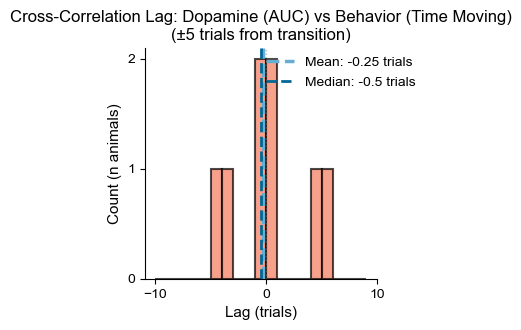

In [97]:
# Plot histogram of lags
f, ax = plt.subplots(figsize=(3, 3))

# Histogram of trial-by-trial lags
ax.hist(cross_corr_df['lag_trials'], bins=np.arange(-10, 10, 1), 
        color=colors[2], alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axvline(cross_corr_df['lag_trials'].mean(), color=colors[0], linestyle='--', linewidth=2.5,
          label=f'Mean: {cross_corr_df["lag_trials"].mean():.2f} trials')
ax.axvline(cross_corr_df['lag_trials'].median(), color=colors[1], linestyle='--', linewidth=2,
          label=f'Median: {cross_corr_df["lag_trials"].median():.1f} trials')
ax.axvline(0, color='gray', linestyle=':', linewidth=1, alpha=0.5)

ax.set_xlabel('Lag (trials)', fontsize=11)
ax.set_ylabel('Count (n animals)', fontsize=11)
ax.set_title('Cross-Correlation Lag: Dopamine (AUC) vs Behavior (Time Moving)\n(±5 trials from transition)', fontsize=12)
ax.set_xticks(range(-10, 11, 10))
ax.set_yticks([0,1,2])
ax.legend(fontsize=10, loc=[0.5, 0.8], frameon=False)
sns.despine(ax=ax)

if SAVE_FIGS:
    save_figure(f, "fig4b_cross_correlation_lag", FIGSFOLDER)



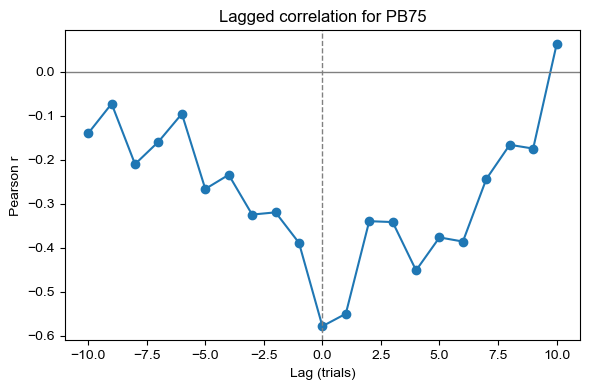

,lag_trials,pearson_r,p_value
0,-10,-0.139596,0.396677
1,-9,-0.072247,0.657753
2,-8,-0.209557,0.188516
3,-7,-0.158655,0.315598
4,-6,-0.095136,0.543955
5,-5,-0.266043,0.080891
6,-4,-0.233802,0.122161
7,-3,-0.324252,0.027918
8,-2,-0.319166,0.028763
9,-1,-0.388455,0.006364


In [98]:
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

animal_to_plot = animal if "animal" in locals() else subset_condition["id"].iloc[0]
max_abs_lag = 10

animal_data = (
    subset_condition
    .query("id == @animal_to_plot")
    .sort_values("trial")
)

x = animal_data["auc_snips"].to_numpy()
y = animal_data["time_moving"].to_numpy()

lag_vals = []
r_vals = []
p_vals = []

for lag in range(-max_abs_lag, max_abs_lag + 1):
    if lag < 0:
        x_lag = x[:lag]
        y_lag = y[-lag:]
    elif lag > 0:
        x_lag = x[lag:]
        y_lag = y[:-lag]
    else:
        x_lag = x
        y_lag = y

    if len(x_lag) >= 3:
        r, p = pearsonr(x_lag, y_lag)
    else:
        r, p = np.nan, np.nan

    lag_vals.append(lag)
    r_vals.append(r)
    p_vals.append(p)

lag_r_df = pd.DataFrame({"lag_trials": lag_vals, "pearson_r": r_vals, "p_value": p_vals})

plt.figure(figsize=(6, 4))
plt.plot(lag_r_df["lag_trials"], lag_r_df["pearson_r"], marker="o")
plt.axhline(0, color="0.5", linewidth=1)
plt.axvline(0, color="0.5", linewidth=1, linestyle="--")
plt.xlabel("Lag (trials)")
plt.ylabel("Pearson r")
plt.title(f"Lagged correlation for {animal_to_plot}")
plt.tight_layout()
plt.show()

lag_r_df

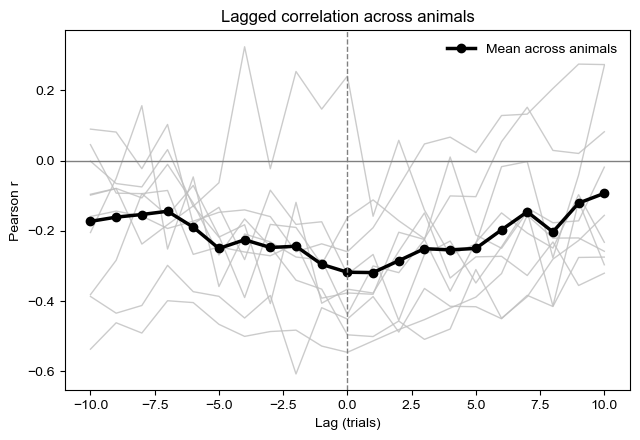

,animal,lag_trials,pearson_r,p_value
0,PB26,-10,0.089832,0.586545
1,PB26,-9,0.081426,0.617440
2,PB26,-8,-0.022842,0.887274
3,PB26,-7,0.103107,0.515836
4,PB26,-6,-0.180337,0.247183


In [76]:
# Quick overlay: lagged Pearson r for all animals + mean
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

max_abs_lag = 10
animals_to_plot = sorted(subset_condition["id"].unique())

all_lag_dfs = []
for animal_name in animals_to_plot:
    animal_data = (
        subset_condition
        .query("id == @animal_name")
        .sort_values("trial")
    )

    x = animal_data["auc_snips"].to_numpy()
    y = animal_data["time_moving"].to_numpy()

    rows = []
    for lag in range(-max_abs_lag, max_abs_lag + 1):
        if lag < 0:
            x_lag = x[:lag]
            y_lag = y[-lag:]
        elif lag > 0:
            x_lag = x[lag:]
            y_lag = y[:-lag]
        else:
            x_lag = x
            y_lag = y

        if len(x_lag) >= 3:
            r_val, p_val = pearsonr(x_lag, y_lag)
        else:
            r_val, p_val = np.nan, np.nan

        rows.append({"animal": animal_name, "lag_trials": lag, "pearson_r": r_val, "p_value": p_val})

    all_lag_dfs.append(pd.DataFrame(rows))

lag_r_all_df = pd.concat(all_lag_dfs, ignore_index=True)
lag_r_mean_df = lag_r_all_df.groupby("lag_trials", as_index=False)["pearson_r"].mean()

plt.figure(figsize=(6.5, 4.5))
for animal_name, df_animal in lag_r_all_df.groupby("animal"):
    plt.plot(df_animal["lag_trials"], df_animal["pearson_r"], color="0.75", linewidth=1, alpha=0.8)

plt.plot(
    lag_r_mean_df["lag_trials"],
    lag_r_mean_df["pearson_r"],
    color="black",
    linewidth=2.5,
    marker="o",
    label="Mean across animals",
)

plt.axhline(0, color="0.5", linewidth=1)
plt.axvline(0, color="0.5", linewidth=1, linestyle="--")
plt.xlabel("Lag (trials)")
plt.ylabel("Pearson r")
plt.title("Lagged correlation across animals")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

lag_r_all_df.head()

In [30]:
# Diagnostic: why max-lag can differ for PB75
from scipy.signal import correlate

animal_check = "PB75"
pb75 = lag_r_all_df.query("animal == @animal_check").copy()

best_by_r = pb75.loc[pb75["pearson_r"].idxmax(), ["lag_trials", "pearson_r"]]
best_by_abs_r = pb75.loc[pb75["pearson_r"].abs().idxmax(), ["lag_trials", "pearson_r"]]

ad = subset_condition.query("id == @animal_check").sort_values("trial")
x = ad["auc_snips"].to_numpy()
y = ad["time_moving"].to_numpy()
xn = (x - x.min()) / (x.max() - x.min() + 1e-10)
yn = (y - y.min()) / (y.max() - y.min() + 1e-10)
cc = correlate(xn, yn, mode="full")
lags_cc = np.arange(-(len(xn) - 1), len(xn))
mask = (lags_cc >= -10) & (lags_cc <= 10)
cc_df = pd.DataFrame({"lag": lags_cc[mask], "cc": cc[mask]})
old_best = cc_df.loc[cc_df["cc"].abs().idxmax()]

print(f"PB75 max by raw r (largest value): lag={int(best_by_r['lag_trials'])}, r={best_by_r['pearson_r']:.3f}")
print(f"PB75 max by |r| (strongest effect): lag={int(best_by_abs_r['lag_trials'])}, r={best_by_abs_r['pearson_r']:.3f}")
print(f"PB75 old cross-corr max by |cc|: lag={int(old_best['lag'])}, cc={old_best['cc']:.3f}")

pb75.sort_values("pearson_r").head(5)

PB75 max by raw r (largest value): lag=-7, r=-0.011
PB75 max by |r| (strongest effect): lag=3, r=-0.509
PB75 old cross-corr max by |cc|: lag=-7, cc=5.925


,animal,lag_trials,pearson_r,p_value
202,PB75,3,-0.509032,0.000303
200,PB75,1,-0.501048,0.000286
199,PB75,0,-0.496141,0.000289
203,PB75,4,-0.479626,0.000857
201,PB75,2,-0.456860,0.001246


In [27]:
lags

array([-48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36,
       -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23,
       -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,
        -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
         4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48])

## Figure 4D: Shuffled data

In [ ]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column, parameter):
    mean = df.groupby(column).mean(numeric_only=True)[parameter]
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

PARAMETER = "auc_snips"

z = subset_aligned.copy()
real_k = fit_sigmoid(z, "trial_aligned", PARAMETER)[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = fits_df.x0_orig.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = fits_df.assign(x0_orig=shuffled_x0s)
    z_temp = make_realigned_trials(z, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned", PARAMETER)[2]

print(real_k)
# print(shuffled_k)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


-1.0283751337151101


In [84]:
def fit_sigmoid(df, column, parameter, initial_k=1):
    mean = df.groupby(column).mean(numeric_only=True)[parameter]
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), initial_k, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return [np.nan]*4
    
def get_shuffled_k(df, parameter, num_repeats=1000, initial_k=1, verbose=False):
    z = df.copy()
    real_k = fit_sigmoid(z, "trial_aligned", parameter, initial_k=initial_k)[2]

    shuffled_k = np.zeros(num_repeats)
    for i in range(num_repeats):
        shuffled_x0s = fits_df.x0_orig.values
        np.random.shuffle(shuffled_x0s)
        df_fitted_params_shuffled = fits_df.assign(x0_orig=shuffled_x0s)
        z_temp = make_realigned_trials(z, df_fitted_params_shuffled, verbose=False)
        shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned", parameter, initial_k=initial_k)[2]
        if verbose:
            print(shuffled_k[i])

    return real_k, shuffled_k


get_shuffled_k(subset_aligned, "time_moving", num_repeats=10, initial_k=1, verbose=True)

18.849329398636193
0.20580976862367123
0.05773699651618333
0.11680978177902412
0.08681934393468596
0.179224093840317
0.04677888263292175
0.19166272580902532
0.05174458206417772
0.3365169529505846


(np.float64(2.4397416536387744),
 array([18.8493294 ,  0.20580977,  0.057737  ,  0.11680978,  0.08681934,
         0.17922409,  0.04677888,  0.19166273,  0.05174458,  0.33651695]))

In [102]:
real_k_da, shuffled_k_da = get_shuffled_k(subset_aligned, "auc_snips", num_repeats=1000, initial_k=-1)

In [ ]:
rea

Text(0.5, 0, 'Steepness of transition (k)')

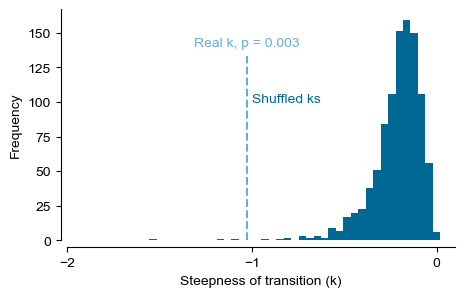

In [106]:
color_shuf = colors[1]
color_real = colors[0]

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k_da, bins=bins, color=color_shuf)
ax.axvline(real_k_da, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k_da, 140,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k_da > real_k_da) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [ ]:
real_k_behav, shuffled_k_behav = get_shuffled_k(subset_aligned, "time_moving", num_repeats=1000, initial_k=1)

c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\jmc010\AppData\Local\mambaforge\envs\default\lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, m

Text(0.5, 0, 'Steepness of transition (k)')

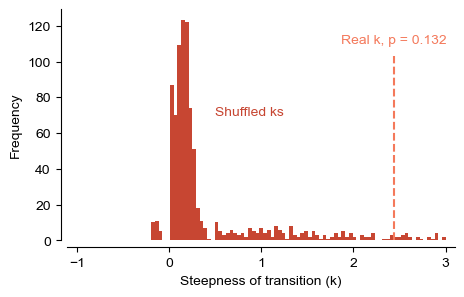

In [100]:
shuf_k = real_k_behav
real_k = shuffled_k_behav

color_shuf = colors[3]
color_real = colors[2]

bins = np.linspace(-1, 3, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuf_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-1.1, 3.1)
ax.set_xticks([-1, 0, 1, 2, 3])
ax.text(real_k, 110,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuf_k < real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(0.5, 70, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

NameError: name 'auc_df' is not defined

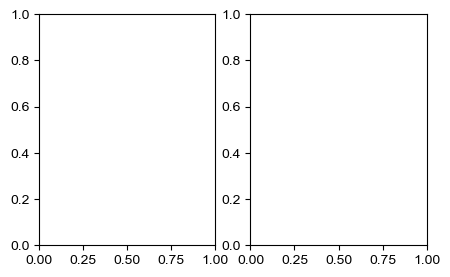

In [74]:
# Plot before/after AUC comparison
f, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plot 1: Individual animal comparisons
ax = axes[0]
x_pos = np.arange(len(auc_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, auc_df['auc_before'], width, label='Before Transition',
                color=colors[0], alpha=0.7, edgecolor='k', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, auc_df['auc_after'], width, label='After Transition',
                color=colors[1], alpha=0.7, edgecolor='k', linewidth=1.5)

ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('Mean Photometry AUC', fontsize=10)
ax.set_title('Photometry AUC Before/After Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
sns.despine(ax=ax)

# Plot 2: Change in AUC
ax = axes[1]
auc_df['auc_change'] = auc_df['auc_after'] - auc_df['auc_before']
colors_change = [colors[1] if x > 0 else colors[0] for x in auc_df['auc_change']]

ax.bar(x_pos, auc_df['auc_change'], color=colors_change, alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('AUC Change (After - Before)', fontsize=10)
ax.set_title('Dopamine Response Change at Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
sns.despine(ax=ax)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_auc_before_after_transition", FIGSFOLDER)
plt.show()

## Export Results

In [ ]:
# Export AUC summary
auc_df.to_csv(RESULTSFOLDER / "transition_aligned_auc_summary.csv", index=False)
print(f"Exported AUC summary to {RESULTSFOLDER / 'transition_aligned_auc_summary.csv'}")

print(f"\nFigure 4B generation complete!")
print(f"Summary:")
print(f"  - {len(animals)} animals with valid transition fits")
print(f"  - {len(subset_aligned)} total trials used for alignment")
print(f"  - Mean AUC change: {auc_df['auc_change'].mean():.3f} ± {auc_df['auc_change'].std():.3f}")